In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install torch torchvision opencv-python pillow numpy scikit-learn seaborn kagglehub

# Import libraries
import os
import random
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Download datasets using kagglehub
real_face_dataset = kagglehub.dataset_download("arnaud58/flickrfaceshq-dataset-ffhq")
fake_face_dataset = kagglehub.dataset_download("shavaizbutt/ai-face-dataset-3000-images")

# Define dataset paths
real_dataset_path = real_face_dataset
fake_dataset_path = fake_face_dataset

100%|██████████| 19.5G/19.5G [08:08<00:00, 42.8MB/s]

Extracting files...


100%|██████████| 3.70G/3.70G [01:34<00:00, 41.8MB/s]

Extracting files...


Total real images found: 52001
Total fake images found: 3000


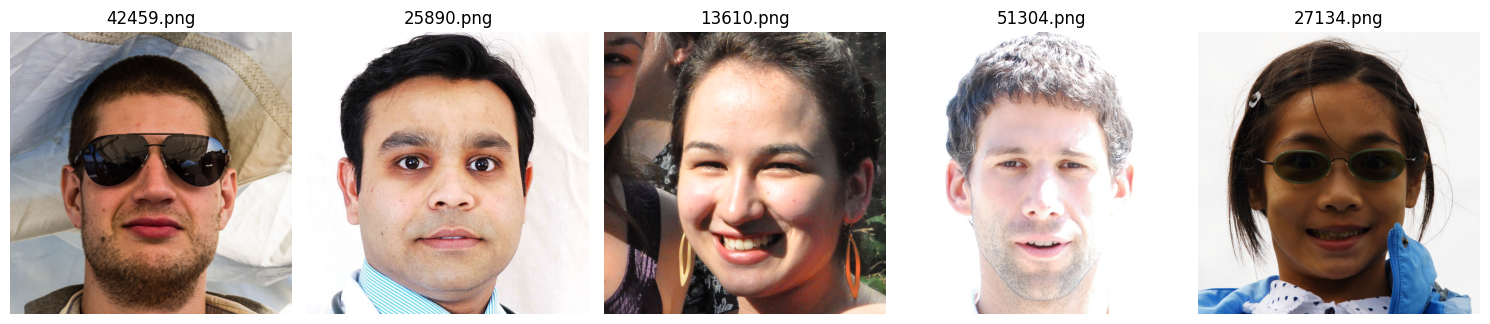

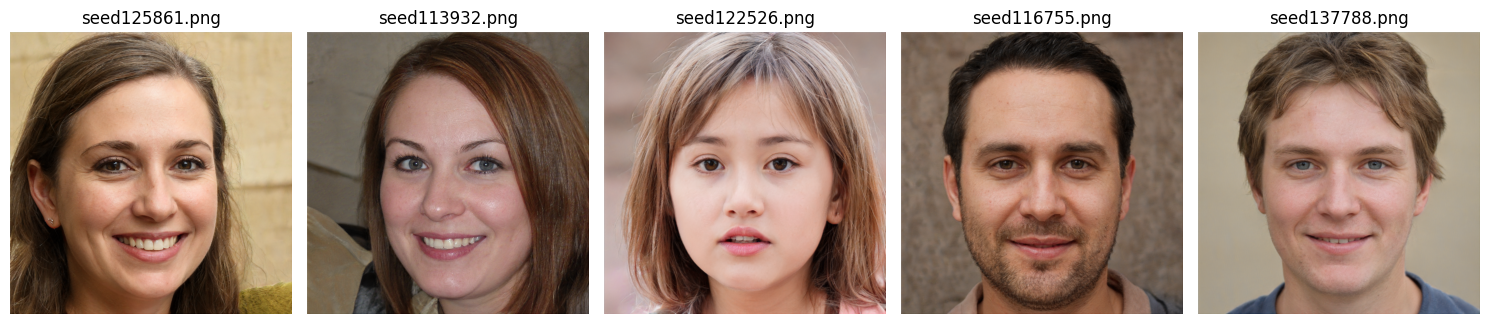

In [4]:
# List all .png images in the dataset folders
real_images = [os.path.join(real_dataset_path, f) for f in os.listdir(real_dataset_path) if f.endswith('.png')]
fake_images = [os.path.join(fake_dataset_path, f) for f in os.listdir(fake_dataset_path) if f.endswith('.png')]

# Safety checks
print(f"Total real images found: {len(real_images)}")
print(f"Total fake images found: {len(fake_images)}")

# Display 5 random real images
sample_real_images = random.sample(real_images, min(5, len(real_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_real_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

# Display 5 random fake images
sample_fake_images = random.sample(fake_images, min(5, len(fake_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_fake_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

In [5]:
# Balance the dataset by selecting 3,000 real images
num_real_images = 3000
if len(real_images) < num_real_images:
    print(f"Warning: Only {len(real_images)} real images available, using all of them.")
    selected_real_images = real_images
else:
    selected_real_images = random.sample(real_images, num_real_images)

# Verify fake images count (should be 3,000 based on dataset description)
if len(fake_images) != num_real_images:
    print(f"Warning: Fake images count ({len(fake_images)}) does not match target ({num_real_images}).")

# Define custom dataset for real and fake images
class DeepfakeDataset(Dataset):
    def __init__(self, real_images, fake_images, transform=None):
        self.real_images = real_images
        self.fake_images = fake_images
        self.transform = transform
        # Create image list and labels (0 for real, 1 for fake)
        self.all_images = real_images + fake_images
        self.labels = [0] * len(real_images) + [1] * len(fake_images)
        # List to store indices of valid images
        self.valid_indices = []
        self.corrupted_files = []

        # Check for valid images during initialization
        for idx in range(len(self.all_images)):
            try:
                img_path = self.all_images[idx]
                image = Image.open(img_path).convert('RGB')
                image.close()  # Close the image to free memory
                self.valid_indices.append(idx)
            except Exception as e:
                self.corrupted_files.append((img_path, str(e)))

        print(f"Total images: {len(self.all_images)}")
        print(f"Valid images: {len(self.valid_indices)}")
        if self.corrupted_files:
            print(f"Corrupted files ({len(self.corrupted_files)}): {self.corrupted_files}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map to valid index
        valid_idx = self.valid_indices[idx]
        img_path = self.all_images[valid_idx]
        label = self.labels[valid_idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # This should not happen due to pre-checking, but included as a safeguard
            print(f"Error loading image {img_path}: {e}")
            return None, None

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create dataset with balanced real images
dataset = DeepfakeDataset(selected_real_images, fake_images, transform=transform)

# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders with custom collate function to handle None values
def custom_collate(batch):
    # Filter out None items
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

Total images: 6000
Valid images: 5997
Corrupted files (3): [('/root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111370.png', 'unrecognized data stream contents when reading image file'), ('/root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111695.png', 'broken data stream when reading image file'), ('/root/.cache/kagglehub/datasets/shavaizbutt/ai-face-dataset-3000-images/versions/1/seed111380.png', 'unrecognized data stream contents when reading image file')]


In [6]:
# Define the ConvNeXt-based classifier
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ConvNeXt-Tiny
        self.convnext = models.convnext_tiny(weights='IMAGENET1K_V1')
        # Modify the final classifier layer for binary classification
        num_ftrs = self.convnext.classifier[2].in_features  # Access the last linear layer
        self.convnext.classifier[2] = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def forward(self, x):
        return self.convnext(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR for ConvNeXt

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 176MB/s]


Epoch [1/10], Train Loss: 0.0754, Val Loss: 0.0056
Epoch [2/10], Train Loss: 0.0060, Val Loss: 0.0052
Epoch [3/10], Train Loss: 0.0043, Val Loss: 0.0029
Epoch [4/10], Train Loss: 0.0080, Val Loss: 0.0093
Epoch [5/10], Train Loss: 0.0032, Val Loss: 0.0034
Epoch [6/10], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [7/10], Train Loss: 0.0001, Val Loss: 0.0010
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0009
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0007
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0001


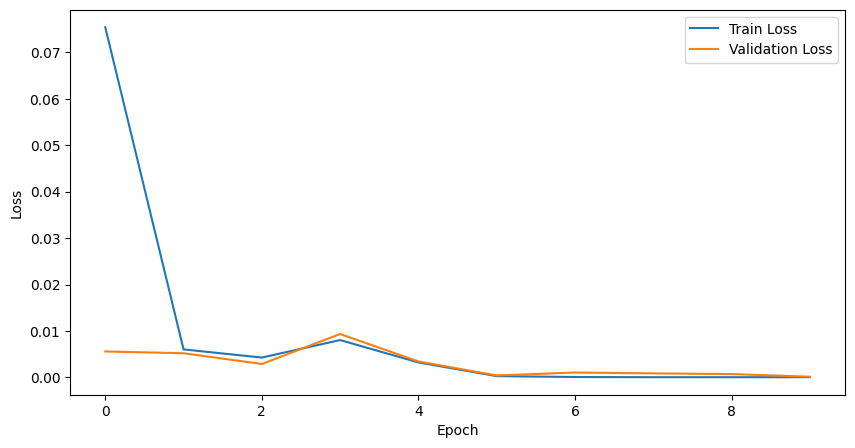

In [7]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    total_samples = 0
    for images, labels in train_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
    epoch_loss = running_loss / total_samples if total_samples > 0 else float('inf')
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    total_val_samples = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Skip empty batches
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            total_val_samples += images.size(0)
    val_epoch_loss = val_loss / total_val_samples if total_val_samples > 0 else float('inf')
    val_losses.append(val_epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


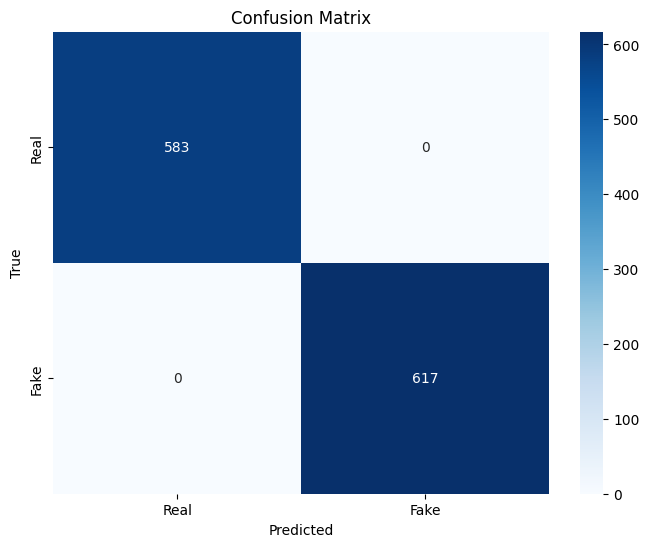

Confusion Matrix:
True Negatives (Real as Real): 583
False Positives (Real as Fake): 0
False Negatives (Fake as Real): 0
True Positives (Fake as Fake): 617


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Evaluate the model on the test set to compute confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float().squeeze().cpu().numpy()
        all_preds.extend(predicted)
        all_labels.extend(labels.squeeze().cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"True Negatives (Real as Real): {cm[0, 0]}")
print(f"False Positives (Real as Fake): {cm[0, 1]}")
print(f"False Negatives (Fake as Real): {cm[1, 0]}")
print(f"True Positives (Fake as Fake): {cm[1, 1]}")

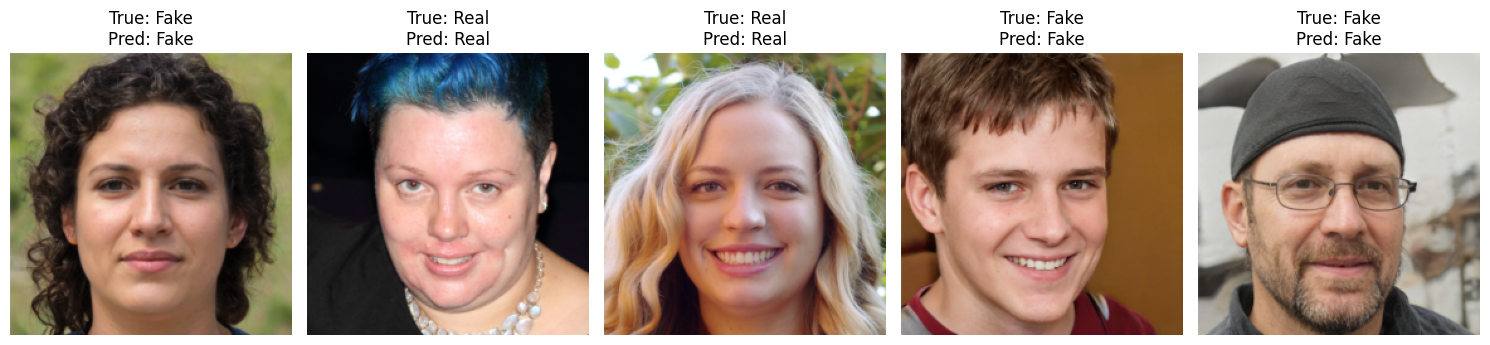

In [10]:
# Visualize predictions on 5 test images
model.eval()
sample_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
images, labels = next(iter(sample_loader))
images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
with torch.no_grad():
    outputs = model(images)
    predicted = (torch.sigmoid(outputs) > 0.5).float()

# Move images to CPU for visualization
images = images.cpu()
labels = labels.cpu().squeeze()
predicted = predicted.cpu().squeeze()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"True: {'Fake' if labels[i] else 'Real'}\nPred: {'Fake' if predicted[i] else 'Real'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/deepfake_convext_model.pth')
print("Model saved to /content/drive/My Drive/deepfake_convext_model.pth")

Model saved to /content/drive/My Drive/deepfake_convext_model.pth


In [37]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import gradio as gr
import numpy as np

# Define the exact same model architecture as your trained model
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ConvNeXt-Tiny (but we'll load the weights from your saved model)
        from torchvision import models
        self.convnext = models.convnext_tiny(weights=None)  # Don't load pretrained weights
        # Modify the final classifier layer for binary classification
        num_ftrs = self.convnext.classifier[2].in_features  # Access the last linear layer
        self.convnext.classifier[2] = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def forward(self, x):
        return self.convnext(x)

# Load the model
def load_model(model_path):
    model = DeepfakeClassifier()

    try:
        # Load the saved state dict
        state_dict = torch.load(model_path, map_location='cpu')
        model.load_state_dict(state_dict)
        model.eval()
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Image preprocessing
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    if image.mode != 'RGB':
        image = image.convert('RGB')

    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Prediction function
def predict_image(image, model):
    if model is None:
        return "Model not loaded properly", 0.0

    try:
        # Preprocess the image
        image_tensor = preprocess_image(image)

        # Make prediction
        with torch.no_grad():
            output = model(image_tensor)  # Single output for binary classification
            probability = torch.sigmoid(output).item()  # Apply sigmoid to get probability

            # probability > 0.5 means FAKE, probability <= 0.5 means REAL
            if probability > 0.5:
                prediction = "FAKE"
                confidence = probability
            else:
                prediction = "REAL"
                confidence = 1 - probability

            return f"Prediction: {prediction}", f"Confidence: {confidence:.2%}"

    except Exception as e:
        return f"Error during prediction: {e}", ""

# Load your model (update the path as needed)
MODEL_PATH = '/content/drive/My Drive/deepfake_convext_model.pth'
model = load_model(MODEL_PATH)

# Gradio interface function
def gradio_predict(image):
    if image is None:
        return "Please upload an image", ""

    prediction, confidence = predict_image(image, model)
    return prediction, confidence

# Create Gradio interface
def create_gradio_interface():
    with gr.Blocks(title="Deepfake Detection", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# 🔍 Deepfake Detection System")
        gr.Markdown("Upload an image to detect if it's real or generated by AI")

        with gr.Row():
            with gr.Column():
                image_input = gr.Image(
                    type="pil",
                    label="Upload Image",
                    height=400
                )
                predict_btn = gr.Button("🔍 Analyze Image", variant="primary", size="lg")

            with gr.Column():
                prediction_output = gr.Textbox(
                    label="Prediction Result",
                    interactive=False,
                    text_align="center"
                )
                confidence_output = gr.Textbox(
                    label="Confidence Score",
                    interactive=False,
                    text_align="center"
                )

        # Examples (you can add sample images here)
        gr.Examples(
            examples=[],  # Add paths to example images if you have any
            inputs=image_input,
            label="Example Images"
        )

        predict_btn.click(
            fn=gradio_predict,
            inputs=image_input,
            outputs=[prediction_output, confidence_output]
        )

        # Auto-predict when image is uploaded
        image_input.change(
            fn=gradio_predict,
            inputs=image_input,
            outputs=[prediction_output, confidence_output]
        )

    return demo

# Launch the interface
if __name__ == "__main__":
    demo = create_gradio_interface()
    demo.launch(
        share=True,  # Creates a public link
        debug=True,
        server_name="0.0.0.0"
    )

Model loaded successfully!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1051f40f904216fa1b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 0.0.0.0:7861 <> https://1051f40f904216fa1b.gradio.live
